In [46]:
from __future__ import division, print_function
import warnings
import os
import re
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix, hstack
from sklearn.model_selection import StratifiedKFold, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from scipy.stats.mstats import gmean
from sklearn.model_selection import cross_val_score
%matplotlib inline
warnings.filterwarnings('ignore')

### Loading training and test samples. In addition, download the dictionary with sites.

In [23]:
PATH_TO_DATA = '../../data/assignment4'
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id')
with open(os.path.join(PATH_TO_DATA, 'site_dic.pkl'), 'rb') as input_file:
    site_dict = pickle.load(input_file)
site_dict['Unknown'] = 0

#Let's sort the data by time. This is useful for cross-validation over time.
train_df = train_df.sort_values(by='time1')

### Let's define functions that will be useful in the course of work.

In [32]:
def get_sites_dict_(data):
    '''
    Gets dataframe with site names (10 columns) as input.
    Returns a dictionary of sites ordered by frequency.
    '''
    m, n = data.shape #num of rows and columns
    data = pd.DataFrame(data.values.reshape(m*n, 1), columns=['site']) #transform to 1 column
    freq = data.site.value_counts().reset_index()
    key_value_df = pd.DataFrame() #contains a pair of site-frequency
    key_value_df['site'] = freq['index']
    key_value_df['count'] = freq['site']
    key_value_df.sort_values(by='count', inplace=True, ascending=False) 
    sites_dict = {} 
    sites_dict['Unknown'] = 0
    for i in np.arange(key_value_df.shape[0]):
        if key_value_df.iloc[i,0]!='Unknown':
            sites_dict[key_value_df.iloc[i,0]] = i+1
    return sites_dict

def inverse_dict(sites_dict):
    '''
    Gets a key-value dictionary. 
    Returns the dictionary by swapping the key and value.
    '''
    code_sites_dict = {}
    sites = list(sites_dict.items())
    for site in sites:
        code_sites_dict[site[1]] = site[0]
    return code_sites_dict

def make_sparse_data(data):
    '''
    Makes sparse matrix
    '''
    n = data.shape[1]
    X = data.values
    flatten_X = X.flatten()
    new_X = ([1]*flatten_X.shape[0], flatten_X, range(0, flatten_X.shape[0]+10, 10))
    X_sparse = csr_matrix(new_X)[:, 1:]
    return X_sparse

def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df=pd.DataFrame(predicted_labels,index=np.arange(1,predicted_labels.shape[0]+1),columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

### Let's combine training and test samples – it will be necessary to bring them together then to the sparse matrix format.

In [25]:
train_test_df = pd.concat([train_df, test_df])

sites = ['site%s' % i for i in range(1, 11)]
times = ['time%s' % i for i in range(1, 11)]
all_features = sites + times

train_test_df_sites = train_test_df[sites].fillna(0).astype('int')
train_test_df_times = train_test_df[times].fillna(0).astype('datetime64')
train_test_df_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


### Create a sparse matrix

In [26]:
#the index by which we will separate the training sample from the test sample
idx_split = train_df.shape[0]

y = train_df['target']
train_test_sparse = make_sparse_data(train_test_df_sites)
X_train_sparse = train_test_sparse[:idx_split, :]
X_test_sparse = train_test_sparse[idx_split:,:]

print('Train DF size: {0}\nTest DF size: {1}\nTarget size: {2}'.format(
    str(X_train_sparse.shape), str(X_test_sparse.shape), str(y.shape)))

Train DF size: (253561, 48371)
Test DF size: (82797, 48371)
Target size: (253561,)


### Step 1. Get rid of the subdomains of 'www.', to bring all sites to one kind. 

Obviously, sites *www.google.com* and *google.com* it's the same. However, such situations in the data generate unnecessary features and make noise.

In [31]:
#Spoiler: this conversion gives a good boost. If you have not done it yet, be sure to use it :)
general_df = pd.concat([train_test_df_sites, train_test_df_times], axis=1) #main df

general_sites = general_df[sites].apply(lambda ts: ts.map(inverse_dict(site_dict))) #instead of numbers the names of sites
general_sites = general_sites.applymap(lambda site: re.sub("^\S*?\.*?www\S*?\.", '', site)) 

new_site_dict = get_sites_dict_(general_sites)

#on a thousand unique sites became less.
print(len(list(site_dict.keys())), len(list(new_site_dict.keys())))
general_sites.head()

              site   count
0          Unknown  168150
1        google.fr  162411
2       google.com  112349
3   annotathon.org  108810
4  apis.google.com   75913
google.fr
48372 47135


,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,safebrowsing.clients.google.com,safebrowsing-cache.google.com,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
54843,safebrowsing.clients.google.com,safebrowsing-cache.google.com,safebrowsing.clients.google.com,safebrowsing-cache.google.com,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
77292,apache.org,apache.org,download.eclipse.org,apache.org,apache.org,webtide.com,download.oracle.com,javadl-esd-secure.oracle.com,caucho.com,apache.org
114021,webtide.com,download.oracle.com,caucho.com,download.oracle.com,webtide.com,apache.org,public.dhe.ibm.com,webtide.com,apache.org,apache.org
146670,public.dhe.ibm.com,jope.ow2.org,download.oracle.com,public.dhe.ibm.com,jope.ow2.org,master.dl.sourceforge.net,apache.org,download.eclipse.org,apache.org,public.dhe.ibm.com


In [33]:
general_df[sites] = general_sites.apply(lambda ts: ts.map(new_site_dict)) #new coding
print(general_df[sites].head())
general_sites_sparse = make_sparse_data(general_df[sites]) #make the first half of the sparse matrix (sites).

            site1  site2  site3  site4  site5  site6  site7  site8  site9  \
session_id                                                                  
21669          30     14      0      0      0      0      0      0      0   
54843          30     14     30     14      0      0      0      0      0   
77292         474    474    529    474    474   1536    126     66   3250   
114021       1536    126   3250    126   1536    474    819   1536    474   
146670        819   2771    126    819   2771   3084    474    529    474   

            site10  
session_id          
21669            0  
54843            0  
77292          474  
114021         474  
146670         819  


### Step 2. Create features.

In [34]:
#1 morning
general_df['morning'] = general_df['time1'].apply(lambda ts: 1 if (ts.hour>=7) & (ts.hour<=11) else 0)
#2 evening
general_df['evening'] = general_df['time1'].apply(lambda ts: 1 if (ts.hour>=19) & (ts.hour<=23) else 0)
#3 start hour
general_df['start_hour'] = general_df['time1'].apply(lambda ts: int(ts.hour))
#4 month
general_df['month'] = general_df['time1'].apply(lambda ts: ts.month)
#5 day of week
general_df['day_of_week'] = general_df['time1'].apply(lambda ts: ts.isoweekday())

general_df.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,...,time6,time7,time8,time9,time10,morning,evening,start_hour,month,day_of_week
session_id,,,,,,,,,,,,,,,,,,,,,
21669,30,14,0,0,0,0,0,0,0,0,...,1970-01-01 00:00:00,1970-01-01 00:00:00,1970-01-01 00:00:00,1970-01-01 00:00:00,1970-01-01 00:00:00,1,0,8,1,6
54843,30,14,30,14,0,0,0,0,0,0,...,1970-01-01 00:00:00,1970-01-01 00:00:00,1970-01-01 00:00:00,1970-01-01 00:00:00,1970-01-01 00:00:00,1,0,8,1,6
77292,474,474,529,474,474,1536,126,66,3250,474,...,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:17,2013-01-12 08:50:17,1,0,8,1,6
114021,1536,126,3250,126,1536,474,819,1536,474,474,...,2013-01-12 08:50:18,2013-01-12 08:50:19,2013-01-12 08:50:19,2013-01-12 08:50:19,2013-01-12 08:50:20,1,0,8,1,6
146670,819,2771,126,819,2771,3084,474,529,474,819,...,2013-01-12 08:50:21,2013-01-12 08:50:21,2013-01-12 08:50:22,2013-01-12 08:50:22,2013-01-12 08:50:22,1,0,8,1,6


In [56]:
general_df['morning2'] = general_df['time2'].apply(lambda ts: 1 if (ts.hour>=7) & (ts.hour<=11) else 0)
#2 evening
general_df['evening2'] = general_df['time2'].apply(lambda ts: 1 if (ts.hour>=19) & (ts.hour<=23) else 0)
#3 start hour
general_df['start_hour2'] = general_df['time2'].apply(lambda ts: int(ts.hour))
#4 month
general_df['month2'] = general_df['time2'].apply(lambda ts: ts.month)
#5 day of week
general_df['day_of_week2'] = general_df['time2'].apply(lambda ts: ts.isoweekday())

general_df.head()



,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,...,morning,evening,start_hour,month,day_of_week,morning2,evening2,start_hour2,month2,day_of_week2
session_id,,,,,,,,,,,,,,,,,,,,,
21669,30,14,0,0,0,0,0,0,0,0,...,1,0,8,1,6,1,0,8,1,6
54843,30,14,30,14,0,0,0,0,0,0,...,1,0,8,1,6,1,0,8,1,6
77292,474,474,529,474,474,1536,126,66,3250,474,...,1,0,8,1,6,1,0,8,1,6
114021,1536,126,3250,126,1536,474,819,1536,474,474,...,1,0,8,1,6,1,0,8,1,6
146670,819,2771,126,819,2771,3084,474,529,474,819,...,1,0,8,1,6,1,0,8,1,6


In [59]:
time1 = ['morning', 'evening', 'start_hour', 'month', 'day_of_week']
time2 = ['morning2', 'evening2', 'start_hour2', 'month2', 'day_of_week2']

### Step 3. Visual analysis of the constructed features.
Let's compare the behavior of Alice and all the others

['morning', 'month', 'day_of_week', 'start_hour', 'evening']


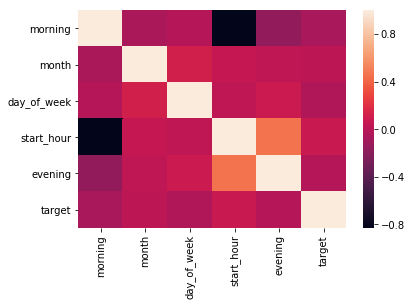

In [60]:
other_features = list(set(general_df.columns) - set(times) - set(sites) - set(time2))
print(other_features)
visual_df = general_df[other_features]
visual_df["target"] = y

#correlations
sns.heatmap(visual_df.corr())

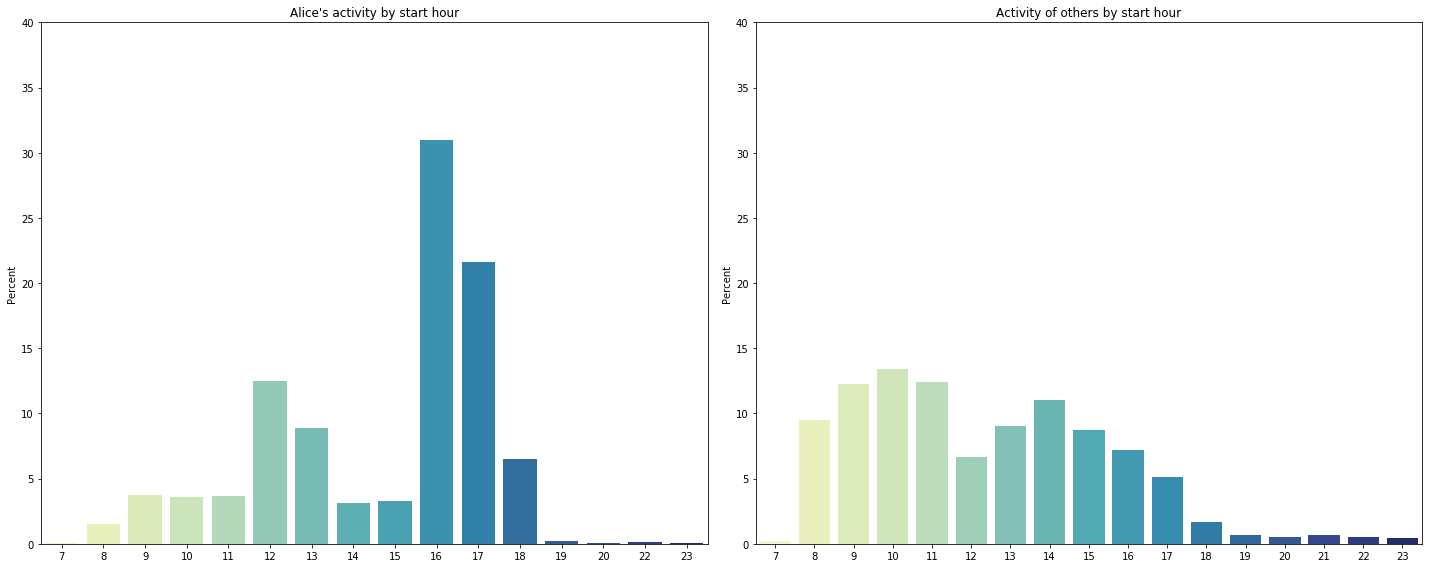

In [15]:
#start_hour
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.title("Alice's activity by start hour")
plt.ylim(0, 40)
values_perc = visual_df[visual_df['target']==1]['start_hour'].value_counts(normalize=True)*100
ax = sns.barplot(values_perc.index, values_perc.values, palette="YlGnBu")
ax.set(ylabel="Percent")

plt.subplot(1, 2, 2)
plt.title("Activity of others by start hour")
plt.ylim(0, 40)
values_perc = visual_df[visual_df['target']==0]['start_hour'].value_counts(normalize=True)*100
ax = sns.barplot(values_perc.index, values_perc.values, palette="YlGnBu")
ax.set(ylabel="Percent")
plt.tight_layout()

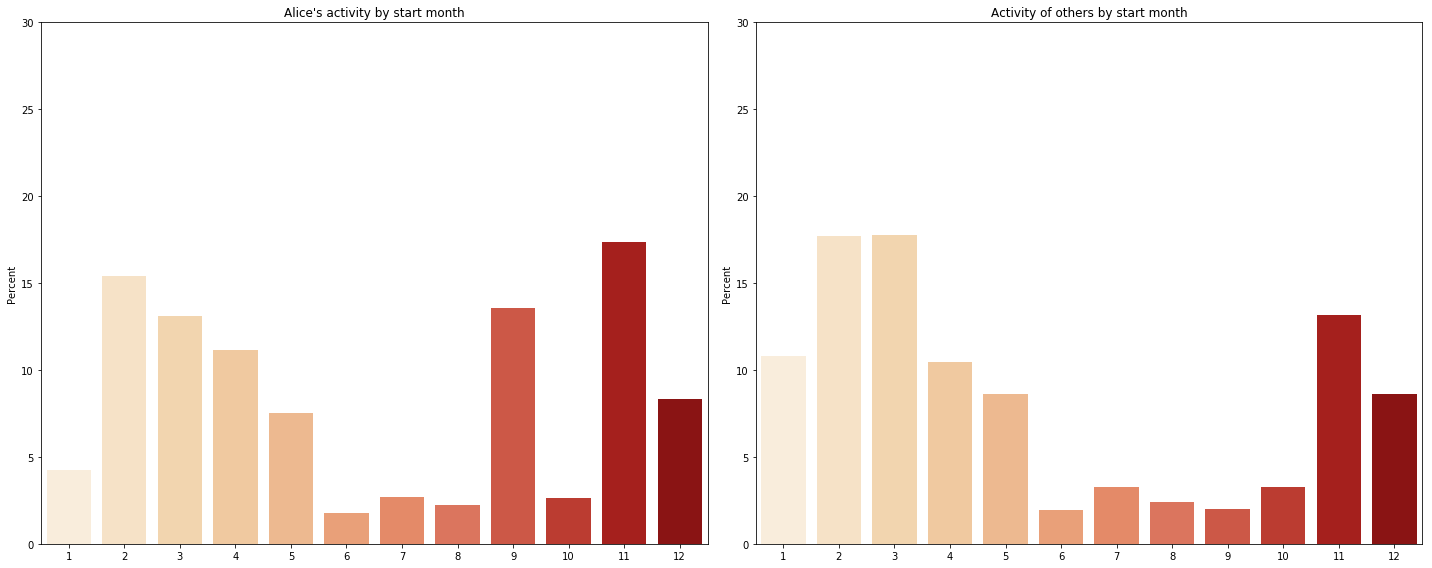

In [16]:
#month
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.title("Alice's activity by start month")
plt.ylim(0, 30)
values_perc = visual_df[visual_df['target']==1]['month'].value_counts(normalize=True)*100
ax = sns.barplot(values_perc.index, values_perc.values, palette="OrRd")
ax.set(ylabel="Percent")

plt.subplot(1, 2, 2)
plt.title("Activity of others by start month")
plt.ylim(0, 30)
values_perc = visual_df[visual_df['target']==0]['month'].value_counts(normalize=True)*100
ax = sns.barplot(values_perc.index, values_perc.values, palette="OrRd")
ax.set(ylabel="Percent")
plt.tight_layout()

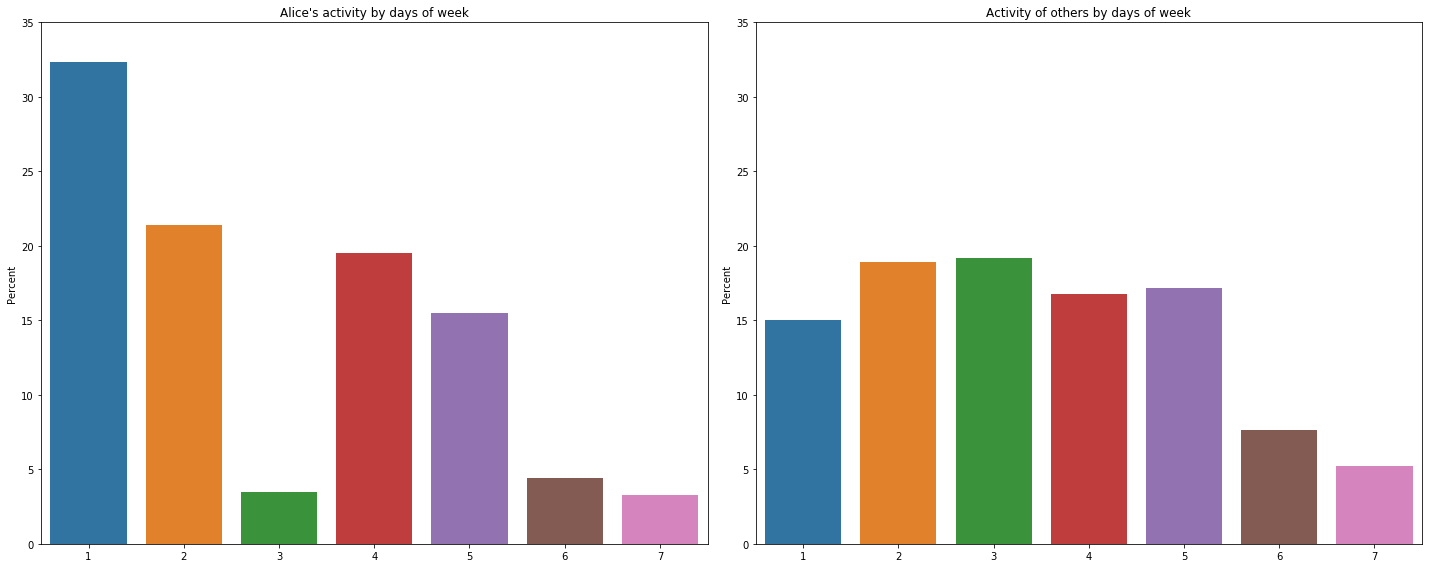

In [17]:
#day of week
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.title("Alice's activity by days of week")
plt.ylim(0, 35)
values_perc = visual_df[visual_df['target']==1]['day_of_week'].value_counts(normalize=True)*100
ax = sns.barplot(values_perc.index, values_perc.values)
ax.set(ylabel="Percent")

plt.subplot(1, 2, 2)
plt.title("Activity of others by days of week")
plt.ylim(0, 35)
values_perc = visual_df[visual_df['target']==0]['day_of_week'].value_counts(normalize=True)*100
ax = sns.barplot(values_perc.index, values_perc.values)
ax.set(ylabel="Percent")
plt.tight_layout()

    - We see that Alice often comes to rest on Monday and much less often comes other Wednesday (as a percentage). 
    - In addition, the timing of the session is very different.
    - But the distribution of the month is almost the same, except that Alice abnormally high activity in September.

### Step 4. Make the binary features with one-hot-encoding.

In [18]:
general_df = pd.get_dummies(general_df, columns=['start_hour'])
general_df = pd.get_dummies(general_df, columns=['month'])
general_df = pd.get_dummies(general_df, columns=['day_of_week'])
general_df = pd.get_dummies(general_df, columns=['start_hour2'])
general_df = pd.get_dummies(general_df, columns=['month2'])
general_df = pd.get_dummies(general_df, columns=['day_of_week2'])
other_features = list(set(general_df.columns) - set(times) - set(sites))
print(other_features)

### Step 5. Building a Model.
Total number of features is 47173.

In [64]:
general_sparse = csr_matrix(hstack([general_sites_sparse, csr_matrix(general_df[other_features])]))

X_train_notimes = general_sparse[:idx_split, :]
X_test_notimes = general_sparse[idx_split:,:]
print(X_train_notimes.shape, X_test_notimes.shape)

(253561, 47179) (82797, 47179)


In [65]:
time_split = TimeSeriesSplit(n_splits=10)
c_values = np.logspace(-2, 2, 10)
logit = LogisticRegression(random_state=97) 
logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=-1, cv=time_split, verbose=1)
logit_grid_searcher.fit(X_train_notimes, y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.1min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=97, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([1.00000e-02, 2.78256e-02, 7.74264e-02, 2.15443e-01, 5.99484e-01,
       1.66810e+00, 4.64159e+00, 1.29155e+01, 3.59381e+01, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [66]:
logit_pred_proba = logit_grid_searcher.predict_proba(X_test_notimes)[:,1]
write_to_submission_file(logit_pred_proba, 'submission_Basasuya.csv')